In [1]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = ""  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.7.0.dev20200721, catalyst: 20.07


In [2]:
import wandb
wandb.login(key=os.environ.get('WANDB_API_KEY'))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /home/alexey/.netrc


True

In [3]:
from pathlib import Path

ROOT = Path("/media/alexey/second/Downloads/semantic_drone_dataset/")

train_image_path = ROOT / "original_images"
train_mask_path = ROOT / "label_images_semantic"

In [4]:
ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)

400

In [5]:
ALL_MASKS = sorted(train_mask_path.glob("*.png"))
len(ALL_MASKS)

400

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np
from catalyst import utils


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(14, 18))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = utils.imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

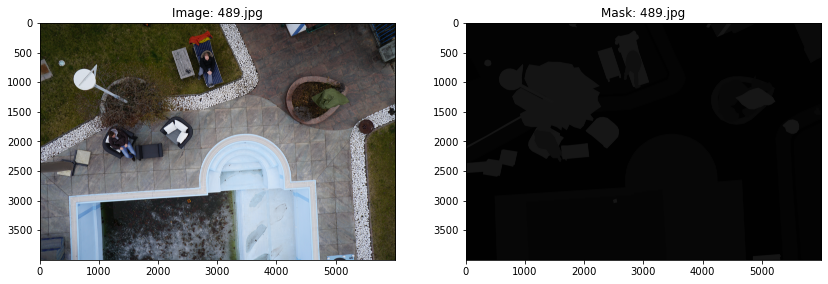

In [7]:
show_random(ALL_IMAGES, ALL_MASKS)

In [8]:
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = utils.imread(self.masks[idx])
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result

In [9]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transforms():
    return [albu.Resize(576, 864, p=1),
           albu.PadIfNeeded(min_height=864, min_width=864, always_apply=True, border_mode=0)]


def hard_transforms():
    result = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.OneOf([
            albu.RandomBrightnessContrast(
              brightness_limit=0.3, contrast_limit=0.3, p=1),
            albu.CLAHE(p=1),
        ],
        p=1,
        ),
        albu.HueSaturationValue(p=0.3)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [10]:
train_transforms = compose([
    pre_transforms(), 
    hard_transforms(),
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([hard_transforms()])

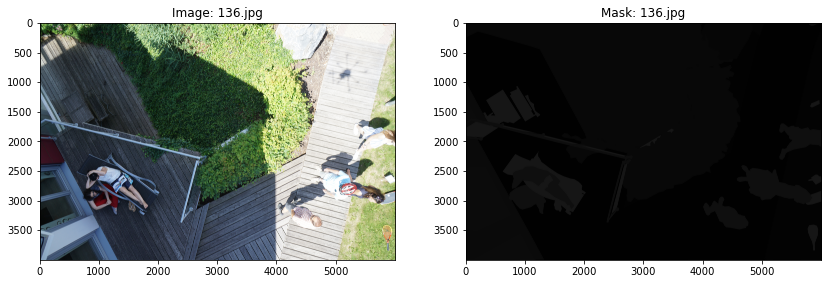

In [11]:
show(index=89, images=ALL_IMAGES, masks=ALL_MASKS)

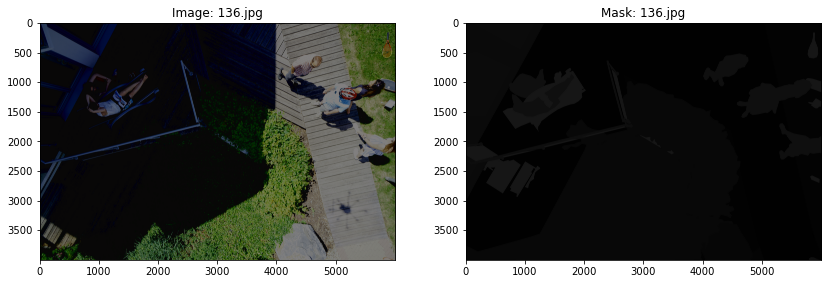

In [12]:
show(index=89, images=ALL_IMAGES, masks=ALL_MASKS, transforms=show_transforms)

In [13]:
from collections import OrderedDict
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.25,
    batch_size: int = 2,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [14]:
is_fp16_used = False
if is_fp16_used:
    batch_size = 4
else:
    batch_size = 2

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=42,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms
)

batch_size: 2


In [15]:
import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="resnext50_32x4d", classes=20)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /home/alexey/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:21<00:00, 4.64MB/s]


In [16]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.CrossEntropyLoss()
}

In [17]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [18]:
from catalyst.dl import SupervisedRunner

num_epochs = 3
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cpu
FP16 params: None


In [46]:
from catalyst import dl

class CustomRunner(dl.Runner):
    
    def predict_batch(self, batch):
        # model inference step
        return self.model(batch[0].to(self.device).view(batch[0].size(0), -1))
    
    def _handle_batch(self, batch):
        x, y = batch
        x = x.view(len(x), -1)
        logits = self.model(x)
        loss = self.state.criterion(logits, y)
        self.state.batch_metrics["loss"] = loss
        
        if self.state.is_train_loader:
            loss.backward()
            self.state.optimizer.step()
            self.state.optimizer.zero_grad() 

In [47]:
runner = CustomRunner()

In [19]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, WandbLogger

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    
    WandbLogger(project='X', name='1')
]


In [55]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    verbose=True
)

wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade





1/3 * Epoch (train):   0% 0/150 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (3) must match the size of tensor b (864) at non-singleton dimension 4

In [70]:
model.classification_head